In [105]:
import os
import math
import itertools
import json
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit import transpile
from qiskit.circuit.library import QAOAAnsatz
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
import numpy as np
from qiskit_optimization.converters import QuadraticProgramToQubo

from qiskit import transpile
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer.primitives import SamplerV2 as AerSamplerV2




In [106]:
def build_vrp_quadratic_program(dist: np.ndarray, n: int, K: int, enforce_subtour: bool = False):
    """Degree-constrained VRP-ish model with x_{i,j} (i != j).

    Degree constraints:
      - For each customer i>=1: out(i)=1 and in(i)=1
      - Depot 0: out(0)=K and in(0)=K

    Note: Subtour constraints are exponential; leave off for larger n (or add a separation routine).
    """
    dist = np.asarray(dist)
    qp = QuadraticProgram()

    for i in range(n):
        for j in range(n):
            if i != j:
                qp.binary_var(f"x_{i}_{j}")

    qp.minimize(linear={f"x_{i}_{j}": float(dist[i, j]) for i in range(n) for j in range(n) if i != j})

    for i in range(1, n):
        qp.linear_constraint({f"x_{i}_{j}": 1 for j in range(n) if j != i}, sense="==", rhs=1, name=f"out_{i}")
        qp.linear_constraint({f"x_{j}_{i}": 1 for j in range(n) if j != i}, sense="==", rhs=1, name=f"in_{i}")

    qp.linear_constraint({f"x_{0}_{j}": 1 for j in range(1, n)}, sense="==", rhs=K, name="out_0")
    qp.linear_constraint({f"x_{j}_{0}": 1 for j in range(1, n)}, sense="==", rhs=K, name="in_0")

    if enforce_subtour and K == 1:
        customers = list(range(1, n))
        for r in range(2, len(customers) + 1):
            for subset in itertools.combinations(customers, r):
                lhs = {f"x_{i}_{j}": 1 for i in subset for j in subset if i != j}
                qp.linear_constraint(lhs, sense="<=", rhs=r - 1, name=f"subtour_{'_'.join(map(str, subset))}")

    return qp




In [107]:

def solve_with_qaoa_local_optimized(qubo, reps=1, maxiter=20, shots=20480, seed=7):
    algorithm_globals.random_seed = seed
    np.random.seed(seed)

    ising_op, offset = qubo.to_ising()
    ansatz = QAOAAnsatz(ising_op, reps=reps)
    nparams = ansatz.num_parameters

    backend = AerSimulator(method="statevector", seed_simulator=seed)
    tqc = transpile(ansatz, backend=backend, optimization_level=3)

    estimator = AerEstimator(run_options={"seed_simulator": seed})

    def energy(theta):
        theta = np.asarray(theta, dtype=float).ravel()
        job = estimator.run([tqc], [ising_op], parameter_values=[theta])
        return float(job.result().values[0] + offset)

    opt = SPSA(maxiter=maxiter)
    x0 = 2*np.pi*np.random.rand(nparams)
    res = opt.minimize(fun=energy, x0=x0)

    return {
        "best_energy": float(res.fun),
        "best_params": np.asarray(res.x, dtype=float),
        "ansatz_transpiled": tqc,
        "backend": backend,     # ✅ REQUIRED for your sampling function
        "seed": seed,
        "shots": shots,
        "reps": reps,
    }



In [108]:

def distance_matrix_to_coordinates(dist, dim=2):
    """
    Convert a distance matrix to coordinates using Classical MDS.

    Parameters:
        dist (ndarray): NxN distance matrix
        dim (int): target dimension (default = 2)

    Returns:
        coords (ndarray): Nx2 array of coordinates
    """
    dist = np.asarray(dist, dtype=float)
    n = dist.shape[0]
    D2 = dist ** 2
    J = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * J @ D2 @ J
    eigvals, eigvecs = np.linalg.eigh(B)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    L = np.diag(np.sqrt(np.maximum(eigvals[:dim], 0)))
    V = eigvecs[:, :dim]
    coords = V @ L
    return coords

# Set random statically
np.random.seed(7)

n =int( input(" enter num of stops")  )       # total nodes (including depot 0)
v = int(input("enter num of v"))         # number of vehicles
scale = 10.0   
dist = np.array([
    [0.000000,  652.924704,  925.938045, 2263.843414,12],
    [652.924704, 0.000000, 1025.132244, 2860.805615,3444],
    [925.938045, 1025.132244, 0.000000, 2884.752641,234],
    [2263.843414, 2860.805615, 2884.752641, 0.000000,345335],
        [843414, 805615, 2884.752641, 23456,0]

], dtype=float)
coords = distance_matrix_to_coordinates(dist)
print("n =", n, "v =", v)



n = 5 v = 3


In [109]:
def run_for_K(K):
        # ## Ploting locations
        import numpy as np   # ← ADD THIS LINE



       

        def plot_edges(coords, edges, title):
            plt.figure()
            plt.scatter(coords[:, 0], coords[:, 1])
            for i, (x, y) in enumerate(coords):
                plt.text(x + 0.1, y + 0.1, str(i))
            for i, j in edges:
                x1, y1 = coords[i]
                x2, y2 = coords[j]
                plt.arrow(x1, y1, x2 - x1, y2 - y1, length_includes_head=True, head_width=0.2)
            plt.title(title)
            plt.xlabel("x"); plt.ylabel("y")
            plt.show()

     
            

        # ## Build QuadraticProgram (VRP degree constraints)




        def build_vrp_quadratic_program(dist: np.ndarray, n: int, K: int, enforce_subtour: bool = False):
            """Degree-constrained VRP-ish model with x_{i,j} (i != j).

            Degree constraints:
            - For each customer i>=1: out(i)=1 and in(i)=1
            - Depot 0: out(0)=K and in(0)=K

            Note: Subtour constraints are exponential; leave off for larger n (or add a separation routine).
            """
            dist = np.asarray(dist)
            qp = QuadraticProgram()

            for i in range(n):
                for j in range(n):
                    if i != j:
                        qp.binary_var(f"x_{i}_{j}")

            qp.minimize(linear={f"x_{i}_{j}": float(dist[i, j]) for i in range(n) for j in range(n) if i != j})

            for i in range(1, n):
                qp.linear_constraint({f"x_{i}_{j}": 1 for j in range(n) if j != i}, sense="==", rhs=1, name=f"out_{i}")
                qp.linear_constraint({f"x_{j}_{i}": 1 for j in range(n) if j != i}, sense="==", rhs=1, name=f"in_{i}")

            qp.linear_constraint({f"x_{0}_{j}": 1 for j in range(1, n)}, sense="==", rhs=K, name="out_0")
            qp.linear_constraint({f"x_{j}_{0}": 1 for j in range(1, n)}, sense="==", rhs=K, name="in_0")

            if enforce_subtour and K == 1:
                customers = list(range(1, n))
                for r in range(2, len(customers) + 1):
                    for subset in itertools.combinations(customers, r):
                        lhs = {f"x_{i}_{j}": 1 for i in subset for j in subset if i != j}
                        qp.linear_constraint(lhs, sense="<=", rhs=r - 1, name=f"subtour_{'_'.join(map(str, subset))}")

            return qp




        # ## Convert to QUBO



        qp = build_vrp_quadratic_program(dist, n, K, enforce_subtour=False)
        print(qp)
        penalty = 500* float(np.max(dist)) 

        converter = QuadraticProgramToQubo(penalty=penalty)

        qubo = converter.convert(qp)




        print("Penalty used:", converter.penalty)
        print("QUBO vars:", qubo.get_num_binary_vars())

        # ## classical base line


        def has_subtour_degree_feasible(edges, n, depot=0):
            # succ map (degree-feasible => exactly one succ per node)
            succ = {i: j for (i, j) in edges}

            visited_global = set()

            for start in range(n):
                if start == depot or start in visited_global:
                    continue

                cur = start
                seen_local = set()

                while True:
                    if cur == depot:
                        # connected to depot, not a subtour
                        visited_global |= seen_local
                        break

                    if cur in seen_local:
                        # found a cycle; if depot not in it => subtour
                        return True

                    seen_local.add(cur)
                    nxt = succ.get(cur, None)
                    if nxt is None:
                        # shouldn’t happen if degree-feasible, but safe
                        visited_global |= seen_local
                        break
                    cur = nxt

            return False

        def vrp_exact_no_subtours(dist: np.ndarray, n: int, K: int):
            """Exact baseline by enumerating K depot tours that partition customers.

            This avoids subtours by construction, but is exponential — use only for small n.
            """
            customers = list(range(1, n))
            m = len(customers)
            if K < 1 or K > m:
                raise ValueError("K must be between 1 and number of customers (n-1).")

            best_cost = float("inf")
            best_routes = None

            # partition customers into K non-empty ordered lists
            for perm in itertools.permutations(customers):
                for cuts in itertools.combinations(range(1, m), K - 1):
                    parts = []
                    start = 0
                    for c in cuts:
                        parts.append(list(perm[start:c]))
                        start = c
                    parts.append(list(perm[start:]))

                    # cost
                    cost = 0.0
                    for r in parts:
                        cost += dist[0, r[0]]
                        for a, b in zip(r, r[1:]):
                            cost += dist[a, b]
                        cost += dist[r[-1], 0]

                    if cost < best_cost:
                        best_cost = cost
                        best_routes = [list(r) for r in parts]

            edges = []
            for r in best_routes:
                edges.append((0, r[0]))
                edges += list(zip(r, r[1:]))
                edges.append((r[-1], 0))

            return best_cost, best_routes, edges

        best_cost, best_routes, best_edges = vrp_exact_no_subtours(dist, n, K)
        print("Exact cost:", best_cost)
        print("Routes:", best_routes)
        #plot_edges(coords, best_edges, f"Best Valid VRP (Cost {best_cost:.2f})")


        # ## helper functions
        # 


        def parse_arc_from_var(name: str):
            # name like 'x_2_3'
            _, i, j = name.split("_")
            return int(i), int(j)

        def build_arc_index(var_names):
            """Precompute arrays arc_i[k], arc_j[k] for fast degree checks."""
            arc_i = np.empty(len(var_names), dtype=np.int32)
            arc_j = np.empty(len(var_names), dtype=np.int32)
            for k, nm in enumerate(var_names):
                arc_i[k], arc_j[k] = parse_arc_from_var(nm)
            return arc_i, arc_j

        def edges_from_bits(bits01, arc_i, arc_j, thresh=0.5):
            bits = np.asarray(bits01).ravel()
            idx = np.flatnonzero(bits >= thresh)
            return list(zip(arc_i[idx].tolist(), arc_j[idx].tolist()))

        def is_degree_feasible_from_bits(bits01, arc_i, arc_j, n: int, K: int):
            """Fast degree feasibility using bincount on selected edges."""
            bits = np.asarray(bits01).ravel().astype(np.int8, copy=False)
            idx = np.flatnonzero(bits)
            out_deg = np.bincount(arc_i[idx], minlength=n)
            in_deg  = np.bincount(arc_j[idx], minlength=n)
            if out_deg[0] != K or in_deg[0] != K:
                return False
            # customers 1..n-1 must have in=out=1
            return bool(np.all(out_deg[1:] == 1) and np.all(in_deg[1:] == 1))

        def objective_cost_from_edges(edges, dist):
            return float(sum(dist[i, j] for (i, j) in edges))


        # translator from qaoa reults to routes



        # Build arc_i / arc_j from QUBO variable order (safe even if QUBO added extra vars)
        qubo_var_names = [v.name for v in qubo.variables]

        arc_i = []
        arc_j = []
        arc_k = []  # index of this arc variable in the bitstring

        for k, name in enumerate(qubo_var_names):
            if name.startswith("x_"):
                _, i, j = name.split("_")
                arc_k.append(k)
                arc_i.append(int(i))
                arc_j.append(int(j))

        arc_k = np.array(arc_k, dtype=int)
        arc_i = np.array(arc_i, dtype=int)
        arc_j = np.array(arc_j, dtype=int)

        print("Total QUBO vars:", len(qubo_var_names))
        print("Arc vars:", len(arc_i), "expected:", n*(n-1))


        # ## QAOA (optimized loop: build ansatz once, transpile once)


        from qiskit_aer import AerSimulator
        from qiskit_aer.primitives import Estimator as AerEstimator
        from qiskit import transpile
        from qiskit.circuit.library import QAOAAnsatz
        from qiskit_algorithms.optimizers import SPSA
        from qiskit_algorithms.utils import algorithm_globals
        import numpy as np

        def solve_with_qaoa_local_optimized(qubo, reps=1, maxiter=20, shots=20480, seed=7):
            algorithm_globals.random_seed = seed
            np.random.seed(seed)

            ising_op, offset = qubo.to_ising()
            ansatz = QAOAAnsatz(ising_op, reps=reps)
            nparams = ansatz.num_parameters

            backend = AerSimulator(method="statevector", seed_simulator=seed)
            tqc = transpile(ansatz, backend=backend, optimization_level=3)

            estimator = AerEstimator(run_options={"seed_simulator": seed})

            def energy(theta):
                theta = np.asarray(theta, dtype=float).ravel()
                job = estimator.run([tqc], [ising_op], parameter_values=[theta])
                return float(job.result().values[0] + offset)

            opt = SPSA(maxiter=maxiter)
            x0 = 2*np.pi*np.random.rand(nparams)
            res = opt.minimize(fun=energy, x0=x0)

            return {
                "best_energy": float(res.fun),
                "best_params": np.asarray(res.x, dtype=float),
                "ansatz_transpiled": tqc,
                "backend": backend,     # ✅ REQUIRED for your sampling function
                "seed": seed,
                "shots": shots,
                "reps": reps,
            }



        qaoa_pack = solve_with_qaoa_local_optimized(qubo, reps=2, maxiter=20, shots=204800, seed=7)
        print("Best energy:", qaoa_pack["best_energy"])


        # ## execute qaoa


        def sample_counts_from_params(qaoa_pack, params, shots=5000):
            from qiskit_aer import AerSimulator

            backend = AerSimulator()
            circ = qaoa_pack["ansatz_transpiled"].copy()

            if not circ.cregs:
                circ.measure_all()

            bound = circ.assign_parameters(params, inplace=False)
            job = backend.run(bound, shots=shots)
            return job.result().get_counts()   # 👈 counts created HERE

        counts = sample_counts_from_params(
            qaoa_pack,
            qaoa_pack["best_params"],
            shots=5000000  
        )


        # ## Collect feasible solutions (fast loop over counts)


        import numpy as np

        # 1. The Filter Function (Detects disconnected loops)
        def has_subtour_degree_feasible(edges, n, depot=0):
            # succ map (degree-feasible => exactly one succ per node)
            succ = {i: j for (i, j) in edges}

            visited_global = set()

            for start in range(n):
                if start == depot or start in visited_global:
                    continue

                cur = start
                seen_local = set()

                while True:
                    if cur == depot:
                        visited_global |= seen_local
                        break

                    if cur in seen_local:
                        # found a cycle not including depot => subtour
                        return True

                    seen_local.add(cur)
                    nxt = succ.get(cur, None)
                    if nxt is None:
                        # dead end (shouldn't happen if degree-feasible)
                        visited_global |= seen_local
                        break
                    cur = nxt

            return False
        def extract_x_bits_from_full_bitstring(bitstr, arc_k, total_qubits=None):
            s = bitstr.replace(" ", "")
            bits_full = np.array([1 if ch == "1" else 0 for ch in s], dtype=np.int8)

            # pad LEFT if shorter than expected
            if total_qubits is not None and len(bits_full) < total_qubits:
                pad = np.zeros(total_qubits - len(bits_full), dtype=np.int8)
                bits_full = np.concatenate([pad, bits_full])

            # try both endianness conventions
            cand1 = bits_full[arc_k]          # normal
            cand2 = bits_full[::-1][arc_k]    # reversed
            return cand1, cand2

        # def bitstring_to_bits_aligned(bitstr, m):
        #     s = bitstr.replace(" ", "")
        #     bits = np.array([1 if ch == "1" else 0 for ch in s], dtype=np.int8)

        #     if len(bits) == m:
        #         return [bits]

        #     # Try taking last m bits and first m bits (we don't know which correspond to vars)
        #     out = []
        #     if len(bits) > m:
        #         out.append(bits[-m:])   # keep rightmost
        #         out.append(bits[:m])    # keep leftmost
        #     else:
        #         # pad with zeros if somehow shorter (rare)
        #         pad = np.zeros(m - len(bits), dtype=np.int8)
        #         out.append(np.concatenate([pad, bits]))
        #         out.append(np.concatenate([bits, pad]))

        #     return out
        # 2. The Main Collector (Now filters BOTH degrees and subtours)
        def collect_feasible_from_counts(counts, arc_k, arc_i, arc_j, dist, n, K, topk=10):
            feas = []

            # find a consistent "expected" length for padding
            total_qubits = max(len(bitstr.replace(" ", "")) for bitstr in counts.keys())

            for bitstr, c in counts.items():
                b1, b2 = extract_x_bits_from_full_bitstring(bitstr, arc_k, total_qubits=total_qubits)

                for b in (b1, b2):
                    if is_degree_feasible_from_bits(b, arc_i, arc_j, n, K):
                        edges = edges_from_bits(b, arc_i, arc_j)

                        if not has_subtour_degree_feasible(edges, n, depot=0):
                            cost = objective_cost_from_edges(edges, dist)
                            feas.append((cost, edges, int(c)))
                            break  # stop after first valid interpretation

            feas.sort(key=lambda t: t[0])
            return feas[:topk], feas

        # Re-run the collection with the new robust filter
        top_valid, all_valid = collect_feasible_from_counts(
        counts,
        arc_k=arc_k,
        arc_i=arc_i,
        arc_j=arc_j,
        dist=dist,
        n=n,
        K=K,
        topk=10
        )
        print(f"Found {len(all_valid)} fully valid solutions (no subtours).")

        if len(top_valid) > 0:
            best_cost, best_edges, count = top_valid[0]
            print(f"Best Valid Cost: {best_cost}")
            #plot_edges(coords, best_edges, f"Best Valid VRP (Cost {best_cost:.2f})")
        else:
            print("No valid tours found. The optimizer might be stuck in subtour-heavy local minima.")

        import json

        # 1. Extract the parameters
        # Convert numpy array to a standard Python list for JSON compatibility
        params_to_save = qaoa_pack["best_params"].tolist()

        # 2. Define a filename (good to include details like 'n5_p3' for n=5, reps=3)
        filename = "qaoa_vrp_params_n5_reps3.json"

        # # 3. Create a dictionary to store context (optional but helpful)
        # data = {
        #     "beta_gamma_params": params_to_save,
        #     "reps": qaoa_pack["reps"],
        #     "best_energy": qaoa_pack["best_energy"],
        #     "note": "Optimized on local simulator, n=5, K=3"
        # }

        # # 4. Save to disk
        # with open(filename, "w") as f:
        #     json.dump(data, f, indent=4)

        # print(f"✅ Parameters saved to {filename}")
        # print(f"Values: {params_to_save}")

        # import json
        # import numpy as np

        # # 1. Load the file
        # filename = "qaoa_vrp_params_n5_reps3.json"

        # with open(filename, "r") as f:
        #     loaded_data = json.load(f)

        # # 2. Restore the parameters as a NumPy array
        # loaded_params = np.array(loaded_data["beta_gamma_params"])

        # print("✅ Parameters loaded.")
        # print(f"Reps: {loaded_data['reps']}")
        # print(f"Values: {loaded_params}")

        # 3. NOW you can skip training and go straight to sampling!
        # You still need to build the circuit first:
        # qaoa_pack = solve_with_qaoa_local_optimized(qubo, reps=loaded_data['reps'], maxiter=0) # maxiter=0 just builds it
        # counts = sample_counts_from_params(qaoa_pack, loaded_params, shots=100000)

        # import json
        # import numpy as np

        # # 1. Load the file
        # filename = "qaoa_vrp_params_n5_reps3.json"

        # with open(filename, "r") as f:
        #     loaded_data = json.load(f)

        # # 2. Restore the parameters as a NumPy array
        # loaded_params = np.array(loaded_data["beta_gamma_params"])

        # print("✅ Parameters loaded.")
        # print(f"Reps: {loaded_data['reps']}")
        # print(f"Values: {loaded_params}")

        # # 3. NOW you can skip training and go straight to sampling!
        # # You still need to build the circuit first:
        # # qaoa_pack = solve_with_qaoa_local_optimized(qubo, reps=loaded_data['reps'], maxiter=0) # maxiter=0 just builds it
        # # counts = sample_counts_from_params(qaoa_pack, loaded_params, shots=100000)

        # from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
        # from qiskit import transpile
        # from qiskit.circuit.library import QAOAAnsatz

        # # 1. Authenticate
        # # If you haven't saved your token yet, uncomment the line below:
        # QiskitRuntimeService.save_account(channel="ibm_cloud", token="yor_token", overwrite=True)

        # service = QiskitRuntimeService(channel="ibm_cloud")

        # # 2. Select the Least Busy Backend (Real Hardware)
        # # We filter for devices with at least 127 qubits to ensure good connectivity, 
        # # though your problem only needs ~20.
        # backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)

        # print(f"🚀 Selected Backend: {backend.name}")
        # print(f"   Pending Jobs: {backend.status().pending_jobs}")

        # # 3. Re-create the Clean Ansatz
        # # We use the QUBO and Reps from your simulation results
        # ising_op, offset = qubo.to_ising()
        # reps = qaoa_pack["reps"]
        # ansatz = QAOAAnsatz(ising_op, reps=reps)

        # # 4. Transpile for the Real Backend
        # # optimization_level=3 is CRITICAL here. It uses AI to find the 
        # # best physical qubits on the chip to reduce noise.
        # print("Targeting hardware... (this may take a minute)")
        # tqc_real = transpile(ansatz, backend=backend, optimization_level=3)

        # print(f"✅ Transpilation Complete.")
        # print(f"   Original Qubits: {ansatz.num_qubits}")
        # print(f"   Physical Qubits Used: {tqc_real.num_qubits} (mapped to chip)")
        # print(f"   Circuit Depth: {tqc_real.depth()}")

        # from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
        # from qiskit import transpile
        # from qiskit.circuit.library import QAOAAnsatz

        # # 1. Re-Connect (if needed)
        # backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
        # sampler = Sampler(mode=backend)
        # sampler.options.default_shots = 100000

        # # 2. Re-create the Circuit WITH MEASUREMENTS
        # ising_op, offset = qubo.to_ising()
        # reps = qaoa_pack["reps"]
        # ansatz = QAOAAnsatz(ising_op, reps=reps)

        # # --- CRITICAL FIX: Add Measurements ---
        # ansatz.measure_all() 
        # # --------------------------------------

        # # 3. Transpile for Hardware
        # print(f"Targeting {backend.name}...")
        # tqc_real = transpile(ansatz, backend=backend, optimization_level=3)

        # # 4. Submit Job
        # final_params = qaoa_pack["best_params"]
        # pubs = [(tqc_real, final_params)]

        # print(f"Submitting corrected job with 100,000 shots...")
        # job = sampler.run(pubs)

        # print(f"🎉 Job Submitted! Job ID: {job.job_id()}")
        # print(f"View status at: https://quantum.ibm.com/jobs/{job.job_id()}")
        # # Wait for the job to complete
        # result = job.result()
        # pub_result = result[0]

        # # Now .meas will exist!
        # counts_bitstring = pub_result.data.meas.get_counts()

        # print(f"Success! Received {len(counts_bitstring)} bitstrings.")

        # # Decode
        # top_real, all_real = collect_feasible_from_counts(
        # counts_bitstring, arc_k,
        # arc_i, arc_j, dist, n, K, 
        # topk=20
        # )


        # if top_real:
        #     best_cost, best_edges, count = top_real[0]
        #     print(f"Best Solution: Cost {best_cost} (Count: {count})")
        #     plot_edges(coords, best_edges, f"IBM Quantum: Cost {best_cost}")
        # else:
        #     print("No fully valid tours found in this run.")




        return {"best_cost": best_cost, "best_edges": best_edges}



In [110]:
import matplotlib.pyplot as plt
import numpy as np

def plot_edges(coords, edges, title="Solution"):
    plt.figure(figsize=(10, 8))
    
    # 1. Plot Nodes
    # Depot (Node 0) in Green
    plt.scatter(coords[0, 0], coords[0, 1], c='green', s=300, label="Depot", zorder=3)
    # Customers (Nodes 1+) in Red
    plt.scatter(coords[1:, 0], coords[1:, 1], c='red', s=150, label="Customer", zorder=3)
    
    # 2. Label Nodes
    for i, (x, y) in enumerate(coords):
        plt.text(x, y + 50, str(i), fontsize=12, ha='center', zorder=4) # +50 offset for large scale

    # 3. Plot Arrows
    for (i, j) in edges:
        start = coords[i]
        end = coords[j]
        
        # Direction vector
        dx = end[0] - start[0]
        dy = end[1] - start[1]
        
        # Draw Arrow
        # head_width=80 and head_length=100 make them visible on a 3000-unit map
        plt.arrow(start[0], start[1], dx, dy,
                  head_width=80,    # LARGE value for large coordinates
                  head_length=100,  # LARGE value for large coordinates
                  fc='blue', ec='blue',
                  length_includes_head=True,
                  alpha=0.6,
                  zorder=2)

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [111]:
import matplotlib.pyplot as plt
import numpy as np

def plot_edges(coords, edges, title="Solution"):
    plt.figure(figsize=(10, 10)) # Square figure helps with aspect ratio
    
    # --- 1. Dynamic Arrow Sizing ---
    # Calculate the spread of the data to size arrows automatically
    x_range = coords[:, 0].max() - coords[:, 0].min()
    y_range = coords[:, 1].max() - coords[:, 1].min()
    max_range = max(x_range, y_range)
    
    # Set arrow head size to roughly 2-3% of the map size
    arrow_width = max_range * 0.02
    arrow_length = max_range * 0.03
    
    # --- 2. Plot Nodes ---
    # Depot (Node 0) in Green
    plt.scatter(coords[0, 0], coords[0, 1], c='green', s=300, label="Depot", zorder=10)
    # Customers (Nodes 1+) in Red
    plt.scatter(coords[1:, 0], coords[1:, 1], c='red', s=150, label="Customer", zorder=10)
    
    # --- 3. Label Nodes ---
    # Offset labels slightly so they don't cover the dots
    label_offset = max_range * 0.02 
    for i, (x, y) in enumerate(coords):
        plt.text(x, y + label_offset, str(i), fontsize=12, ha='center', fontweight='bold', zorder=11)

    # --- 4. Plot Arrows ---
    for (i, j) in edges:
        start = coords[i]
        end = coords[j]
        
        dx = end[0] - start[0]
        dy = end[1] - start[1]
        
        plt.arrow(start[0], start[1], dx, dy,
                  head_width=arrow_width,   # calculated above
                  head_length=arrow_length, # calculated above
                  fc='blue', ec='blue',
                  length_includes_head=True,
                  alpha=0.7,
                  zorder=5) # Lower zorder so arrows go UNDER nodes

    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # --- CRITICAL FIX FOR SKEWED ARROWS ---
    plt.axis('equal') 
    
    plt.show()


Running K = 1
minimize 652.924704*x_0_1 + 925.938045*x_0_2 + 2263.843414*x_0_3 + 12*x_0_4 + 652.924704*x_1_0 + 1025.132244*x_1_2 + 2860.805615*x_1_3 + 3444*x_1_4 + 925.938045*x_2_0 + 1025.132244*x_2_1 + 2884.752641*x_2_3 + 234*x_2_4 + 2263.843414*x_3_0 + 2860.805615*x_3_1 + 2884.752641*x_3_2 + 345335*x_3_4 + 843414*x_4_0 + 805615*x_4_1 + 2884.752641*x_4_2 + 23456*x_4_3 (20 variables, 10 constraints, '')
Penalty used: 421707000.0
QUBO vars: 20
Exact cost: 9046.533914
Routes: [[4, 2, 1, 3]]
Total QUBO vars: 20
Arc vars: 20 expected: 20


C:\Users\leena\AppData\Local\Temp\ipykernel_15356\1027679857.py:279: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  qaoa_pack = solve_with_qaoa_local_optimized(qubo, reps=2, maxiter=20, shots=204800, seed=7)
C:\Users\leena\AppData\Local\Temp\ipykernel_15356\1027679857.py:279: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  qaoa_pack = solve_with_qaoa_local_optimized(qubo, reps=2, maxiter=20, shots=204800, seed=7)
c:\Users\leena\miniconda3\envs\qaoa_new\lib\site-packages\qiskit_algorithms\optimizers\spsa.py:353: UserWarning: Calibration failed, using 0.6283185307179586 for `a`
  warnings.warn(f"Calibration failed, using {target_magnitude} for `a`")


Best energy: 8504220166.345093
Found 8 fully valid solutions (no subtours).
Best Valid Cost: 27631.900362

Running K = 2
minimize 652.924704*x_0_1 + 925.938045*x_0_2 + 2263.843414*x_0_3 + 12*x_0_4 + 652.924704*x_1_0 + 1025.132244*x_1_2 + 2860.805615*x_1_3 + 3444*x_1_4 + 925.938045*x_2_0 + 1025.132244*x_2_1 + 2884.752641*x_2_3 + 234*x_2_4 + 2263.843414*x_3_0 + 2860.805615*x_3_1 + 2884.752641*x_3_2 + 345335*x_3_4 + 843414*x_4_0 + 805615*x_4_1 + 2884.752641*x_4_2 + 23456*x_4_3 (20 variables, 10 constraints, '')
Penalty used: 421707000.0
QUBO vars: 20
Exact cost: 9102.496416999998
Routes: [[3], [4, 2, 1]]
Total QUBO vars: 20
Arc vars: 20 expected: 20


C:\Users\leena\AppData\Local\Temp\ipykernel_15356\1027679857.py:279: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  qaoa_pack = solve_with_qaoa_local_optimized(qubo, reps=2, maxiter=20, shots=204800, seed=7)
C:\Users\leena\AppData\Local\Temp\ipykernel_15356\1027679857.py:279: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  qaoa_pack = solve_with_qaoa_local_optimized(qubo, reps=2, maxiter=20, shots=204800, seed=7)


Best energy: 7443487453.43992
Found 71 fully valid solutions (no subtours).
Best Valid Cost: 9102.496416999998

Running K = 3
minimize 652.924704*x_0_1 + 925.938045*x_0_2 + 2263.843414*x_0_3 + 12*x_0_4 + 652.924704*x_1_0 + 1025.132244*x_1_2 + 2860.805615*x_1_3 + 3444*x_1_4 + 925.938045*x_2_0 + 1025.132244*x_2_1 + 2884.752641*x_2_3 + 234*x_2_4 + 2263.843414*x_3_0 + 2860.805615*x_3_1 + 2884.752641*x_3_2 + 345335*x_3_4 + 843414*x_4_0 + 805615*x_4_1 + 2884.752641*x_4_2 + 23456*x_4_3 (20 variables, 10 constraints, '')
Penalty used: 421707000.0
QUBO vars: 20
Exact cost: 9656.226922
Routes: [[1], [3], [4, 2]]
Total QUBO vars: 20
Arc vars: 20 expected: 20


C:\Users\leena\AppData\Local\Temp\ipykernel_15356\1027679857.py:279: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  qaoa_pack = solve_with_qaoa_local_optimized(qubo, reps=2, maxiter=20, shots=204800, seed=7)
C:\Users\leena\AppData\Local\Temp\ipykernel_15356\1027679857.py:279: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  qaoa_pack = solve_with_qaoa_local_optimized(qubo, reps=2, maxiter=20, shots=204800, seed=7)


Best energy: 8684698779.274595
Found 22 fully valid solutions (no subtours).
Best Valid Cost: 9656.226922
Best Valid Cost: 9102.496416999998


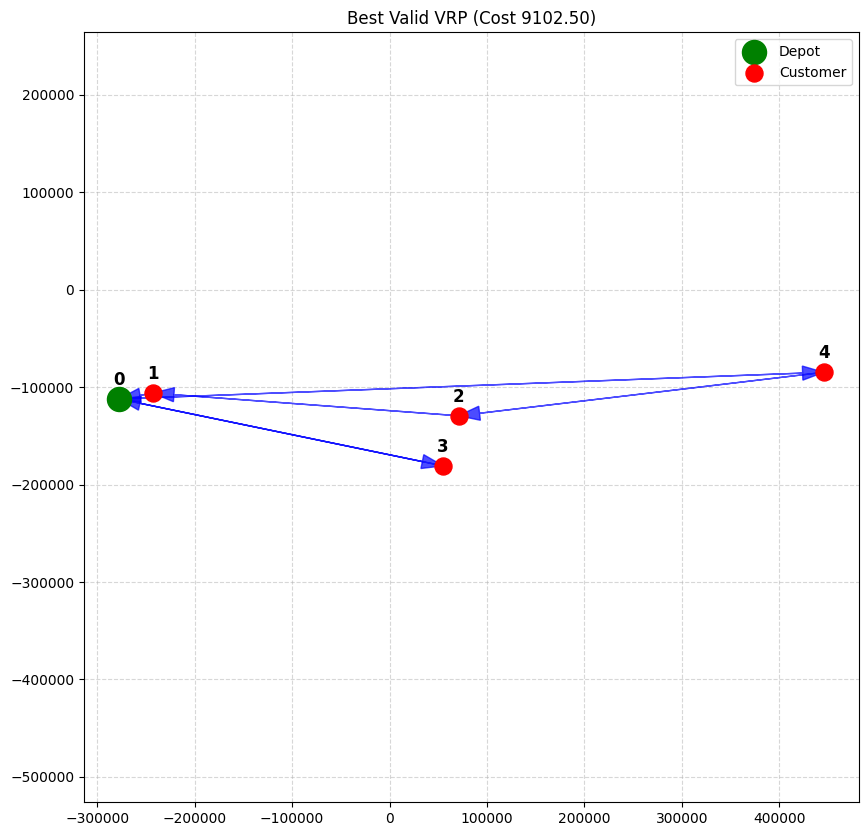

In [112]:
# --- Run for different K values ---
results_by_K = {}
bestcost=99999999999999
bestedges={}
command=input("enter True for limited False for multipleint")
if command=="True":
     results_by_K[K] = run_for_K(K)
     print(f"Best Valid Cost: {bestcost}")
     plot_edges(coords, bestedges, f"Best Valid VRP (Cost {bestcost:.2f})")
else:
    for K in range(1, v+1):
        print('\n' + '='*60)
        print('Running K =', K)
        results_by_K[K] = run_for_K(K)
        if results_by_K[K]["best_cost"] < bestcost:
            bestcost = results_by_K[K]["best_cost"]
            bestedges = results_by_K[K]["best_edges"]
    print(f"Best Valid Cost: {bestcost}")
    plot_edges(coords, bestedges, f"Best Valid VRP (Cost {bestcost:.2f})")

